In [1]:
import json

import matplotlib.pyplot as plt

from muutils.zanj import ZANJ
from maze_transformer.generation.lattice_maze import SolvedMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.dataset.maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.dataset.maze_dataset_configs import MAZE_DATASET_CONFIGS

print(MAZE_DATASET_CONFIGS.keys())

LOCAL_DATA_PATH: str = "../data/"

dict_keys(['test-g3-n5-a_dfs-h73396'])


you should always see `test-g3-n5-a_dfs-h73396` in the list of available dataset configs

In [2]:
def plot_dataset_mazes(ds: MazeDataset, count: int|None = None):
	count = count or len(ds)
	if count == 0:
		print(f"No mazes to plot for dataset")
		return
	fig, axes = plt.subplots(1, count, figsize=(15, 5))
	if count == 1:
		axes = [axes]
	for i in range(count):
		axes[i].imshow(ds[i].as_pixels())
		# remove ticks
		axes[i].set_xticks([])
		axes[i].set_yticks([])

def print_dataset_mazes(ds: MazeDataset, count: int|None = None):
	count = count or len(ds)
	if count == 0:
		print(f"No mazes to print for dataset")
		return
	for i in range(count):
		print(ds[i].as_ascii(), "\n\n-----\n")


In [3]:
zanj: ZANJ = ZANJ(external_list_threshold=256)
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test",
	grid_n=3,
	n_mazes=32,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
)

print(cfg.to_fname())

test-g3-n32-a_dfs-h15603


In [4]:
dataset: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
    save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False, # parallel generation has overhead, not worth it unless you're doing a lot of mazes
)

generating & solving mazes: 100%|██████████| 32/32 [00:00<00:00, 842.18maze/s]


In [5]:
dataset_cpy: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=True,
	do_generate=False,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
)


In [6]:
assert dataset.cfg == dataset_cpy.cfg
print(len(dataset), len(dataset_cpy))
print(dataset_cpy[0])
assert all(x == y for x,y in zip(dataset, dataset_cpy))

32 32
SolvedMaze(connection_list=array([[[ True,  True,  True],
        [ True, False,  True],
        [False, False, False]],

       [[False, False, False],
        [False,  True, False],
        [ True,  True, False]]]), generation_meta={'func_name': 'gen_dfs', 'grid_shape': array([3, 3]), 'start_coord': array([0, 1]), 'visited_cells': [[0, 1], [1, 2], [2, 1], [0, 0], [1, 1], [2, 0], [0, 2], [2, 2], [1, 0]], 'n_accessible_cells': 9, 'max_tree_depth': 18, 'fully_connected': True}, start_pos=array([1, 2]), end_pos=array([0, 0]), solution=array([[1, 2],
       [2, 2],
       [2, 1],
       [2, 0],
       [1, 0],
       [0, 0]]))


In [7]:
dataset_filtered: MazeDataset = dataset.filter_by.path_length(min_length=3)

print(f"{len(dataset) = }")
print(f"{len(dataset_filtered) = }")

len(dataset) = 32
len(dataset_filtered) = 27


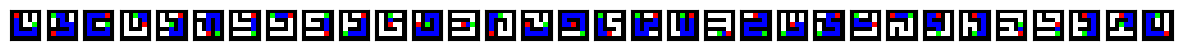

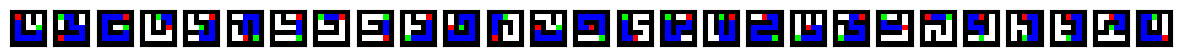

In [8]:
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered)


In [9]:
print(json.dumps(dataset_filtered.cfg.serialize()["applied_filters"], indent=2))
print(f"{MazeDataset._FILTER_NAMESPACE = }")

[
  {
    "name": "path_length",
    "args": [],
    "kwargs": {
      "min_length": 3
    }
  }
]
MazeDataset._FILTER_NAMESPACE = <class 'maze_transformer.dataset.maze_dataset.MazeDatasetFilters'>


In [10]:
dataset_filtered_from_scratch: MazeDataset = MazeDataset.from_config(
	dataset_filtered.cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=False,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False,
)

generating & solving mazes: 100%|██████████| 27/27 [00:00<00:00, 901.04maze/s]


In [ ]:
plot_dataset_mazes(dataset_filtered_from_scratch)
dataset_filtered_nodupe = dataset_filtered_from_scratch.filter_by.remove_duplicates()
plot_dataset_mazes(dataset_filtered_nodupe)


In [ ]:
dataset_filtered_custom: MazeDataset = dataset.custom_maze_filter(
	lambda m, p: len(m.solution) == p,
	p=5,
)
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered_custom)

In [ ]:
dataset_with_meta = dataset.filter_by.collect_generation_meta()

print(json.dumps(dataset_with_meta.serialize()['generation_metadata_collected'], indent=2))

In [ ]:
dataset_not_fully_connected = MazeDataset.from_config(
	MazeDatasetConfig(
		name="test_disconnected",
		grid_n=10,
		n_mazes=32,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(
			n_accessible_cells = 70,
        	max_tree_depth = 15,
		),
	),
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
)

In [ ]:
plot_dataset_mazes(dataset_not_fully_connected, 5)